In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Testing using cartpole example

In [2]:
env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
print(device)

cuda




Transition - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.

ReplayMemory - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    


## DQN

Our goal is to maximize the discounted, cumulative reward (the return).

The discount is a constant between 0 and 1, that ensures convergence. A lower discount means that the agent will prefer immediate rewards over future ones. A higher discount means that the agent will prefer long-term rewards.
A lower discount also prioritizes rewards closer in time, creating a short-sighted, quickly converging model.
This is what balances exploration and exploitation.

The idea is that if we had a function Q* : state x action -> return, then the optimal policy π* would be to take the action with the highest expected return:
π*(s) = argmax_a Q*(s,a)
But, since we don't know this function Q*, we try to estimate it through neural networks. Since neural networks are unviersal function approximators, we can create a universal function and train it to resemble the unknown Q*.

For our training update rule, we can use the fact that the Q function for some policy obeys the Bellman equation:
$$Q^{\pi}(s,a) = r + \gamma Q^{\pi}(s',\pi(s'))$$
The difference between the two sides of this equality is the temporal difference error, $\delta$:
$$\delta = Q(s,a) - (r+\gamma maxQ(s',a))$$

To minimize this error, we will use the Huber loss. The Huber loss acts like the mean squared error when the error is small, but like the mean absolute error when the error is large - this makes it more robust to outliers when the estimates of $Q$ are very noisy. We calculate this over a batch of transitions, $B$, sampled from the replay memory:
$$L = \frac{1}{|B|}\sum_{(s,a,s',r)\in B}h(\delta)$$

## Q-network
Our model will be a feed forward neural network that takes in the difference between the current and previous screen patches. It has two outputs, representing $Q(s,left)$ and $Q(s,right)$ (where $s$ is the input to the network). In effect, the network is trying to predict the expected return of taking each action given the current input.


In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Training

### Epsilon greedy policy

During training, we’ll use a strategy known as epsilon greedy. This is a way to balance exploration and exploitation. With this strategy, the action that is known to give the highest reward is chosen most of the time. However, sometimes we want to explore, so, there is a probability epsilon to choose a random action instead.

- Epsilon: A hyperparameter that determines the probability of taking a random action.

- Greedy Action: The action with the highest expected value (Q-value).

### Hyperparameters and utilities

This cell instantiates our model and its optimizer, and defines some utilities:

- select_action - will select an action according to an epsilon greedy policy. Simply put, we’ll sometimes use our model for choosing the action, and sometimes we’ll just sample one uniformly. The probability of choosing a random action will start at EPS_START and will decay exponentially towards EPS_END. EPS_DECAY controls the rate of the decay.

- plot_durations - a helper for plotting the duration of episodes, along with an average over the last 100 episodes (the measure used in the official evaluations). The plot will be underneath the cell containing the main training loop, and will update after every episode.


In [5]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500
TAU = 0.005
LR = 3e-4


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training loop

optimize_model: function that performs a single step of optimization. It first samples a batch, concatenates all the tensors into a single one, computes $Q(s_{t},a_{t})$ and $V(s_{t+1})=max_{a}Q(s_{t+1},a)$, and combines them into our loss. By definition, we set $V(s)=0$ if $s$ is a terminal state. We also use a target network to comupte $V(s_{t+1})$ for added stability. The target network is updated at every step with a soft update controlled by the hyperparameter TAU, which was previously defined.

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset the environment and obtain the initial state Tensor. Then, we sample an action, execute it, observe the next state and the reward (always 1), and optimize our model once. When the episode ends (our model fails), we restart the loop.

Below, num_episodes is set to 600 if a GPU is available, otherwise 50 episodes are scheduled so training does not take too long. However, 50 episodes is insufficient for to observe good performance on CartPole. You should see the model constantly achieve 500 steps within 600 training episodes. Training RL agents can be a noisy process, so restarting training can produce better results if convergence is not observed.

Complete


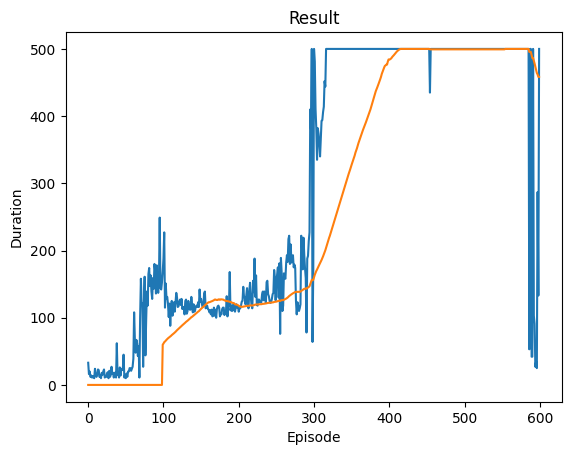

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

### See the trained model

In [14]:
import time

# Visualize the trained agent
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
done = False

while not done:
    env.render()
    action_probs = policy_net(state)
    action = select_action(state)
    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
    state = torch.Tensor(next_state)
    time.sleep(0.01)

env.close()

KeyboardInterrupt: 